# Supply Chain Analytics

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Projects/Supply Chain Analytics/

/content/drive/MyDrive/Projects/Supply Chain Analytics


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb

In [4]:
# Import Data
data = pd.read_csv('supply_chain_data.csv')
print(data.shape)
data.head()

(100, 24)


,Product type,SKU,Price,Availability,Number of products sold,Revenue generated,Customer demographics,Stock levels,Lead times,Order quantities,...,Location,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs
0,haircare,SKU0,69.808006,55,802,8661.996792,Non-binary,58,7,96,...,Mumbai,29,215,29,46.279879,Pending,0.226410,Road,Route B,187.752075
1,skincare,SKU1,14.843523,95,736,7460.900065,Female,53,30,37,...,Mumbai,23,517,30,33.616769,Pending,4.854068,Road,Route B,503.065579
2,haircare,SKU2,11.319683,34,8,9577.749626,Unknown,1,10,88,...,Mumbai,12,971,27,30.688019,Pending,4.580593,Air,Route C,141.920282
3,skincare,SKU3,61.163343,68,83,7766.836426,Non-binary,23,13,59,...,Kolkata,24,937,18,35.624741,Fail,4.746649,Rail,Route A,254.776159
4,skincare,SKU4,4.805496,26,871,2686.505152,Non-binary,5,3,56,...,Delhi,5,414,3,92.065161,Fail,3.145580,Air,Route A,923.440632


**Data Description**
* Product Type: The type of product associated with specific data in the supply chain.
* SKU (Stock Keeping Unit): Unique code used to identify a particular product.
* Price: The price of the product or item in the supply chain.
* Availability: Information about product availability.
* Number of Products Sold: The number of products that have been sold in a certain time period.
* Revenue Generated: Total revenue generated from product sales in a certain time period.
* Customer demographics: Information about customer characteristics, such as age, gender, geographic location, etc.
* Stock Levels: The number of products still available in stock at any given time.
* Lead Times: The time required to order or receive products from suppliers.
* Order Quantities: The number of products ordered in one order or shipment.
* Shipping Times: The time required to ship products from the warehouse or distribution center to customers.
* Shipping Carriers: Companies or services used to ship products to customers.
* Shipping Costs: Costs associated with shipping products, including delivery fees and additional fees.
* Supplier Name: Name of supplier or vendor who provides products or materials to the company.
* Location: The physical location associated with the data in the supply chain, such as the location of a warehouse or distribution center.
* Lead Time: The time required to obtain products or materials from a particular supplier.
* Production Volumes: The number of products produced in a certain time period.
* Manufacturing Lead Time: The time required to produce a product, from ordering materials until the product is ready.
* Manufacturing Costs: Costs related to the production process, including raw material costs, labor, etc.
* Inspection Results: Results of product or material quality inspection.
* Defect Rates: The level of defects or defects in the products produced.
* Transportation Modes: The transportation mode used to send products, such as land, sea or air.
* Routes: Routes or paths used to send products from one point to another in the supply chain.
* Costs: Costs related to various aspects of the supply chain, including transportation costs, production costs, and other costs.

In [5]:
data.describe()

,Price,Availability,Number of products sold,Revenue generated,Stock levels,Lead times,Order quantities,Shipping times,Shipping costs,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Defect rates,Costs
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000
mean,49.462461,48.400000,460.990000,5776.048187,47.770000,15.960000,49.220000,5.750000,5.548149,17.080000,567.840000,14.77000,47.266693,2.277158,529.245782
std,31.168193,30.743317,303.780074,2732.841744,31.369372,8.785801,26.784429,2.724283,2.651376,8.846251,263.046861,8.91243,28.982841,1.461366,258.301696
min,1.699976,1.000000,8.000000,1061.618523,0.000000,1.000000,1.000000,1.000000,1.013487,1.000000,104.000000,1.00000,1.085069,0.018608,103.916248
25%,19.597823,22.750000,184.250000,2812.847151,16.750000,8.000000,26.000000,3.750000,3.540248,10.000000,352.000000,7.00000,22.983299,1.009650,318.778455
50%,51.239831,43.500000,392.500000,6006.352023,47.500000,17.000000,52.000000,6.000000,5.320534,18.000000,568.500000,14.00000,45.905622,2.141863,520.430444
75%,77.198228,75.000000,704.250000,8253.976921,73.000000,24.000000,71.250000,8.000000,7.601695,25.000000,797.000000,23.00000,68.621026,3.563995,763.078231
max,99.171329,100.000000,996.000000,9866.465458,100.000000,30.000000,96.000000,10.000000,9.929816,30.000000,985.000000,30.00000,99.466109,4.939255,997.413450


## Data Pre-processing

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product type             100 non-null    object 
 1   SKU                      100 non-null    object 
 2   Price                    100 non-null    float64
 3   Availability             100 non-null    int64  
 4   Number of products sold  100 non-null    int64  
 5   Revenue generated        100 non-null    float64
 6   Customer demographics    100 non-null    object 
 7   Stock levels             100 non-null    int64  
 8   Lead times               100 non-null    int64  
 9   Order quantities         100 non-null    int64  
 10  Shipping times           100 non-null    int64  
 11  Shipping carriers        100 non-null    object 
 12  Shipping costs           100 non-null    float64
 13  Supplier name            100 non-null    object 
 14  Location                 10

There are no missing values in the dataset.

In [7]:
# Check for duplicates
duplicate_rows = data.duplicated()

# Get the number of duplicate rows
num_duplicates = duplicate_rows.sum()

duplicates = data[data.duplicated()]

if num_duplicates > 0:
    print("Duplicate rows:")
    print(duplicates)
else:
  print("There are no duplicates in the dataset.")

There are no duplicates in the dataset.


## Exploratory Data Analysis

### Price by Product

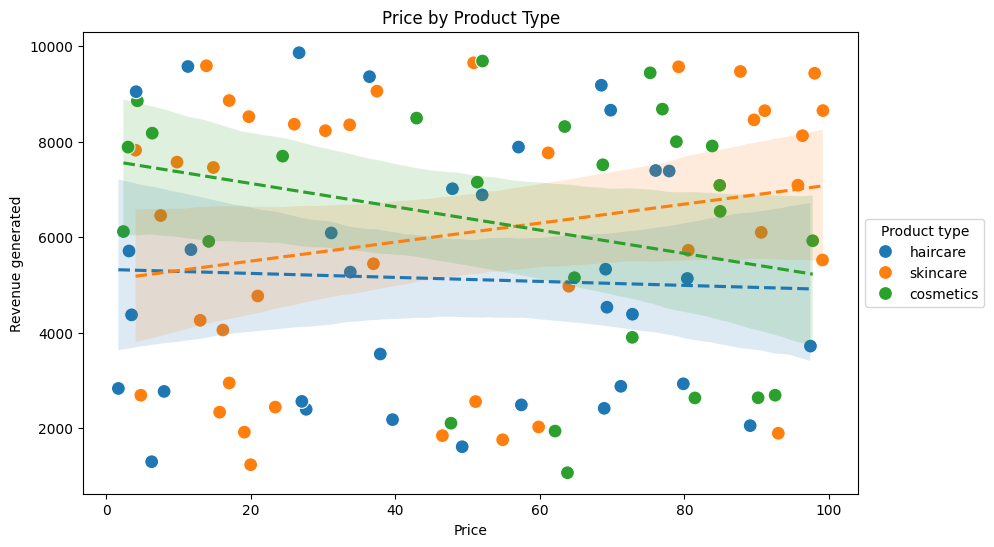

In [8]:
plt.figure(figsize=(10, 6))

# Create a scatter plot with OLS trendlines for each product type
sns.scatterplot(data=data, x='Price', y='Revenue generated', hue='Product type', palette='tab10', s=100)

# Add a trendline for each product category
product_types = data['Product type'].unique()

for product in product_types:
    sns.regplot(data=data[data['Product type'] == product],
                x='Price',
                y='Revenue generated',
                scatter=False,
                #label=f'Trendline ({product})',
                line_kws={"linestyle": "--"})


plt.title('Price by Product Type')
plt.xlabel('Price')
plt.ylabel('Revenue generated')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Product type')
plt.show()

The company derives more revenue from skincare products, and the higher the price of skincare products, the more revenue they generate.

### Sales by Product Type

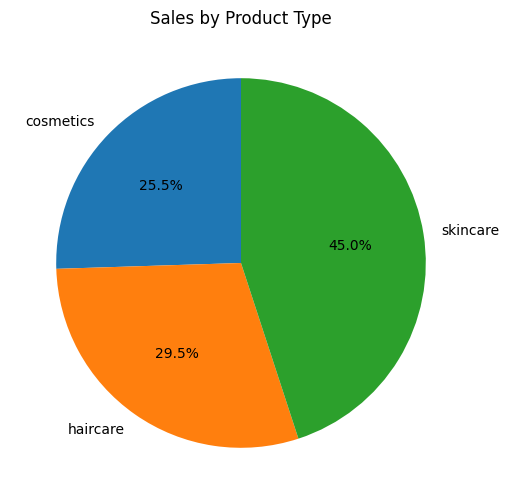

In [9]:
sales_data = data.groupby('Product type')['Number of products sold'].sum().reset_index()

plt.figure(figsize=(10, 6))

plt.pie(sales_data['Number of products sold'], labels=sales_data['Product type'], autopct='%1.1f%%', startangle=90)
plt.title('Sales by Product Type')
plt.show()

45% of revenue comes from skincare products, 29.5% from haircare and 25.5% from cosmetics.

### Total Revenue by Shipping Carrier

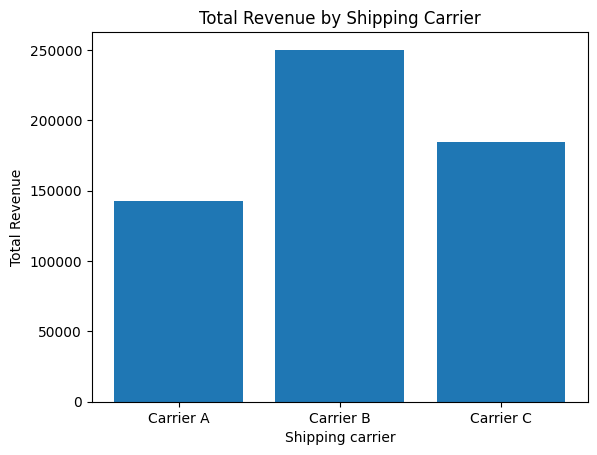

In [10]:
total_revenue = data.groupby('Shipping carriers')['Revenue generated'].sum().reset_index()

plt.bar(total_revenue['Shipping carriers'], total_revenue['Revenue generated'])
plt.xlabel('Shipping carrier')
plt.ylabel('Total Revenue')
plt.title('Total Revenue by Shipping Carrier')
plt.show()

The company uses 3 carriers for shipping and Carrier B generates the most revenue.

### Lead Time and Manufacturing Costs by Product Type

In [11]:
# Calculate average lead time
avg_lead_time = data.groupby('Product type')['Lead time'].mean().reset_index()

# Calculate average manufacturing costs
avg_manufacturing_costs = data.groupby('Product type')['Manufacturing costs'].mean().reset_index()

result = pd.merge(avg_lead_time, avg_manufacturing_costs, on='Product type')
result.rename(columns={'Lead time': 'Average Lead Time', 'Manufacturing costs': 'Average Manufacturing Costs'}, inplace=True)
result

,Product type,Average Lead Time,Average Manufacturing Costs
0,cosmetics,13.538462,43.052740
1,haircare,18.705882,48.457993
2,skincare,18.000000,48.993157


### Analyzing SKU

SKU (Stock Keeping Units) help companies keep track of all the products that are on sale.

#### Revenue Generated by SKU

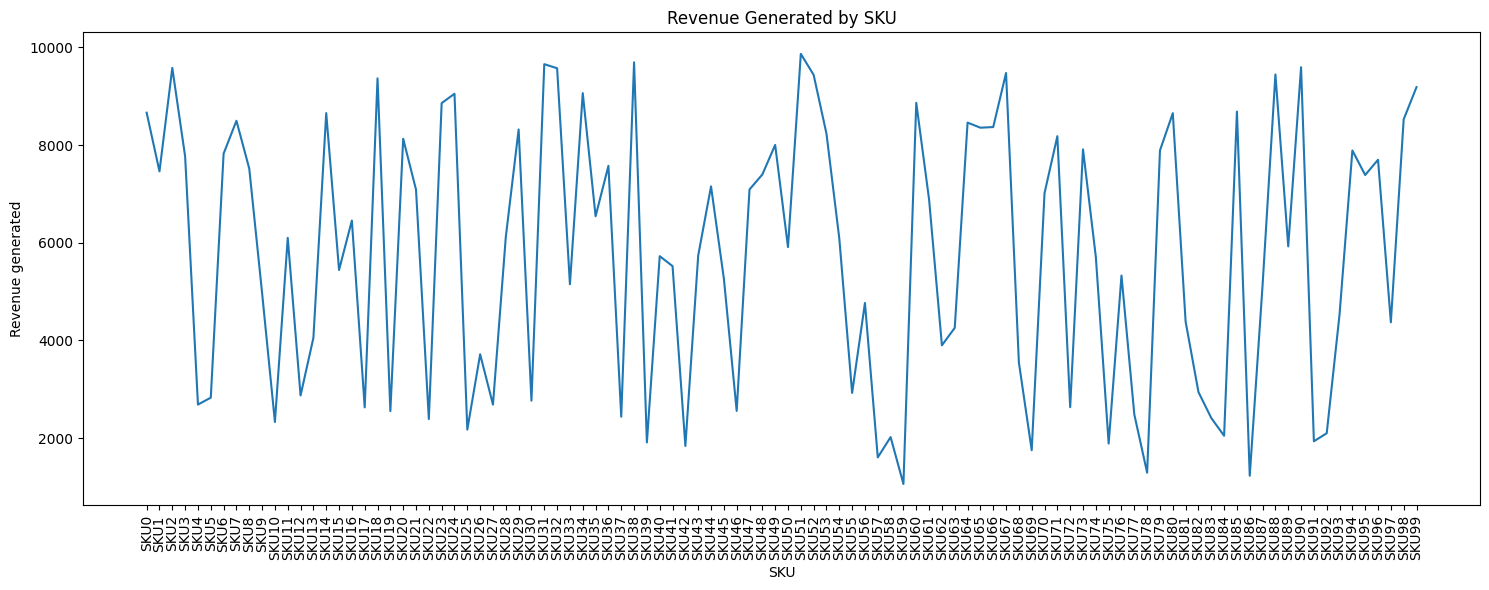

In [12]:
plt.figure(figsize=(15, 6))

sns.lineplot(data=data, x='SKU', y='Revenue generated')
plt.xlabel('SKU')
plt.ylabel('Revenue generated')
plt.title('Revenue Generated by SKU')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Stock Levels by SKU

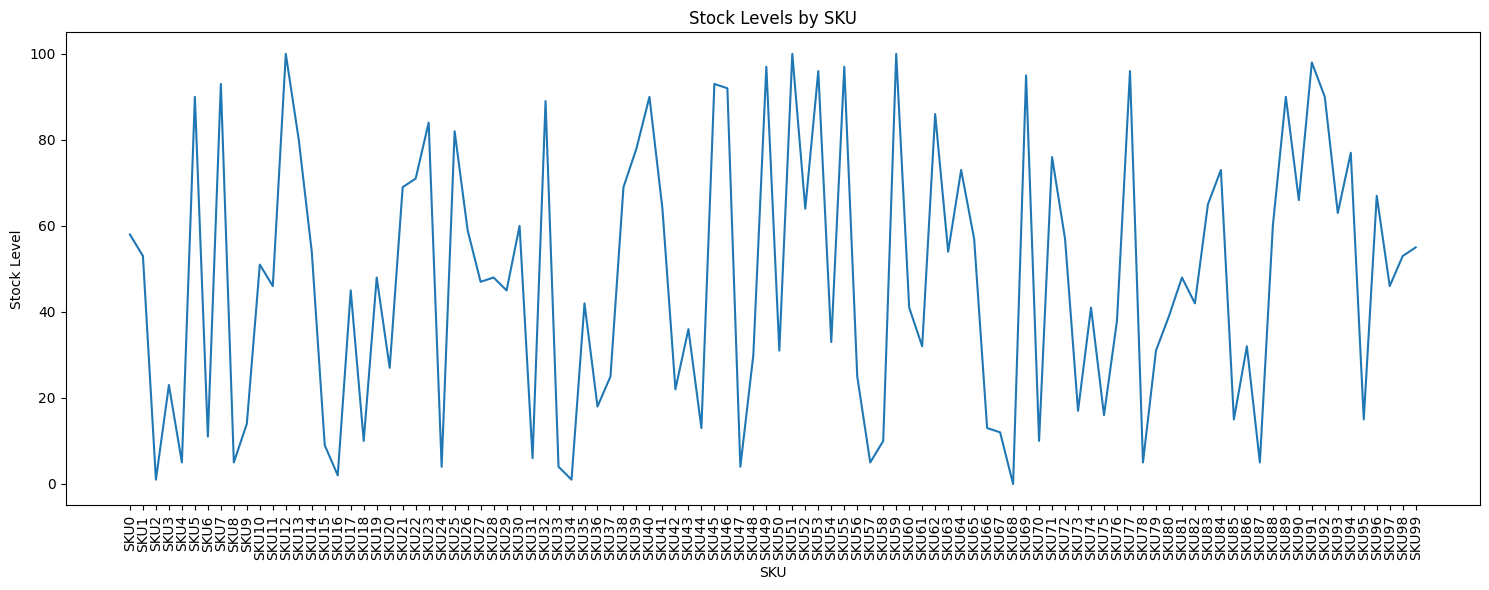

In [13]:
plt.figure(figsize=(15, 6))

sns.lineplot(data=data, x='SKU', y='Stock levels')
plt.xlabel('SKU')
plt.ylabel('Stock Level')
plt.title('Stock Levels by SKU')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Order Quantity by SKU

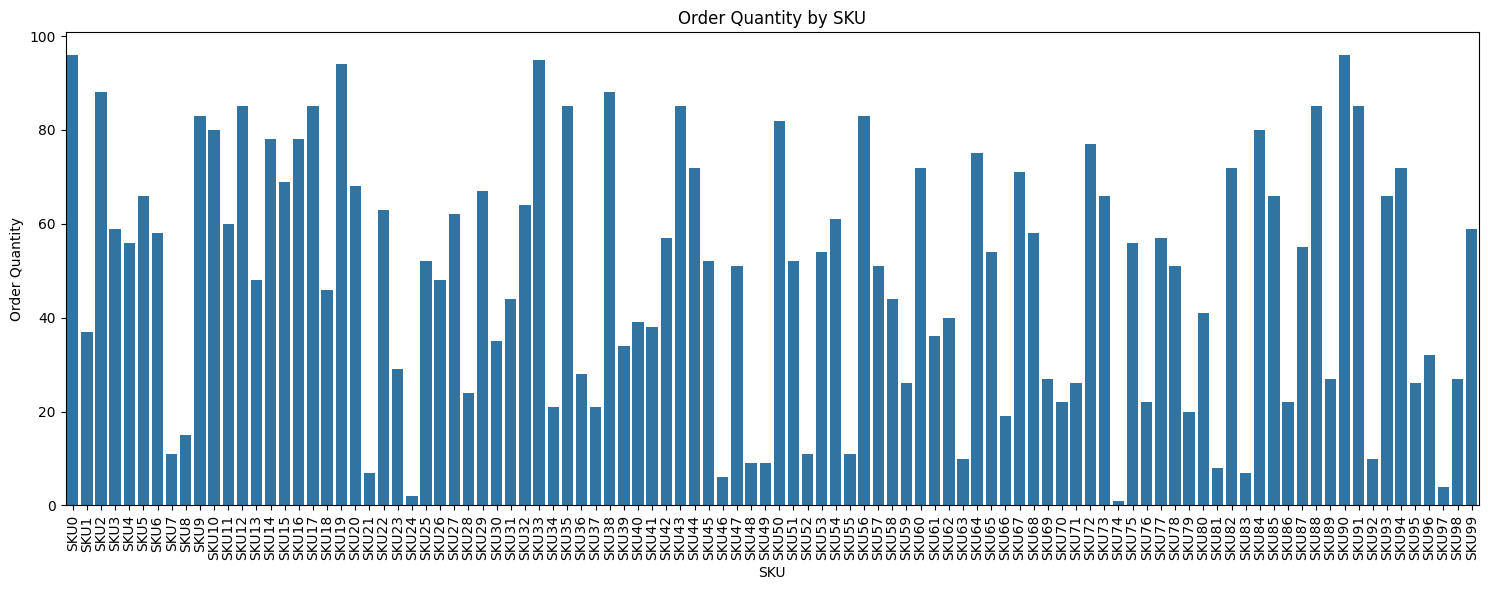

In [14]:
plt.figure(figsize=(15, 6))

sns.barplot(data, x = 'SKU', y = 'Order quantities')
plt.xlabel('SKU')
plt.ylabel('Order Quantity')
plt.title('Order Quantity by SKU')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Shipping Cost by Carrier

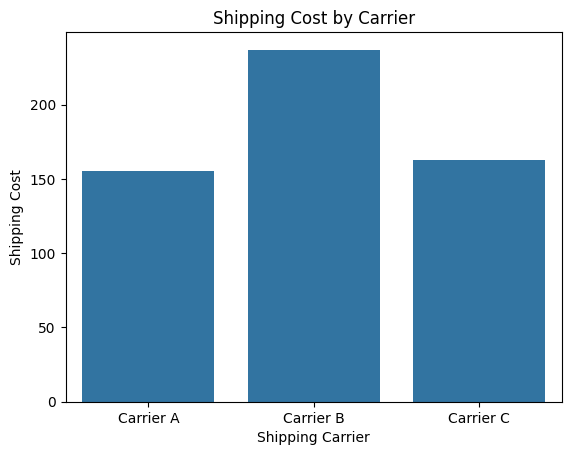

In [15]:
shipping_cost_by_carrier = data.groupby('Shipping carriers')['Shipping costs'].sum().reset_index()

sns.barplot(shipping_cost_by_carrier, x = 'Shipping carriers', y = 'Shipping costs')
plt.xlabel('Shipping Carrier')
plt.ylabel('Shipping Cost')
plt.title('Shipping Cost by Carrier')
plt.show()

Carrier B is the costliest among the three but it also generated most revenue.

### Cost Distribution by Transportation Mode

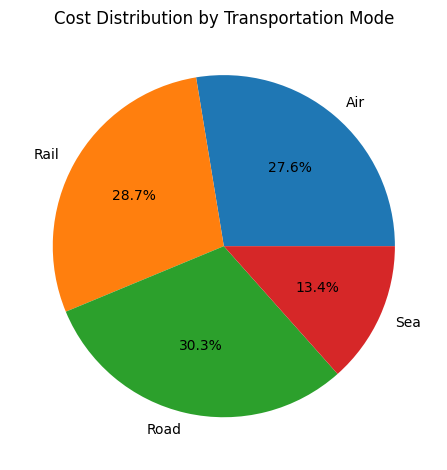

In [16]:
distribution_costs = data.groupby('Transportation modes')['Costs'].sum().reset_index()

plt.pie(distribution_costs['Costs'], labels=distribution_costs['Transportation modes'], autopct='%1.1f%%')
plt.title('Cost Distribution by Transportation Mode')
plt.tight_layout()
plt.show()

Company spends more on Road and Rail modes of transportation.

### Analyzing Defect Rate

The defect rate is the percentage of products that are found defective or broken after shipping.

#### Average Defect Rates by Product Type

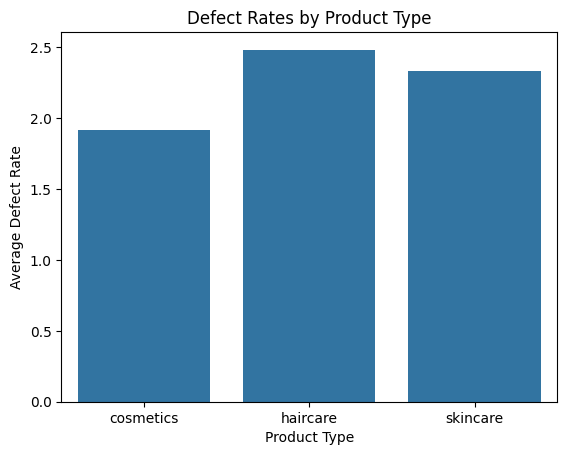

In [17]:
avg_defect_rate = data.groupby('Product type')['Defect rates'].mean().reset_index()

sns.barplot(avg_defect_rate, x = 'Product type', y = 'Defect rates')
plt.xlabel('Product Type')
plt.ylabel('Average Defect Rate')
plt.title('Defect Rates by Product Type')
plt.show()

The defect rate of haricare products are the highest.

#### Defect Rate by Transportation Mode

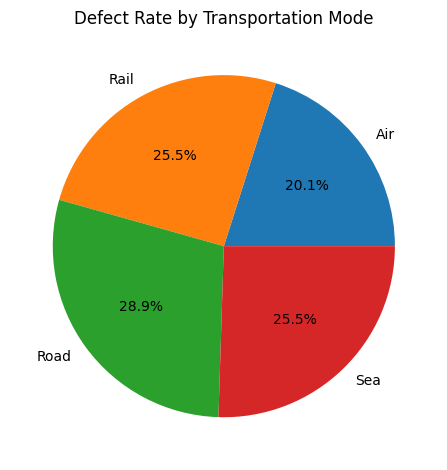

In [18]:
avg_defect_rate = data.groupby('Transportation modes')['Defect rates'].mean().reset_index()


plt.pie(avg_defect_rate['Defect rates'], labels=avg_defect_rate['Transportation modes'], autopct='%1.1f%%')
plt.title('Defect Rate by Transportation Mode')
plt.tight_layout()
plt.show()

Road transportation results in a higher defect rate and Air transportation has the lowest defect rate.

### Supply Chain Risk Assessment

In [19]:
risk_data = data[['SKU', 'Lead times', 'Stock levels']]
risk_data.head()

,SKU,Lead times,Stock levels
0,SKU0,7,58
1,SKU1,30,53
2,SKU2,10,1
3,SKU3,13,23
4,SKU4,3,5


<ipython-input-20-85cb287cf3a0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  risk_data['Risk Score'] = risk_data['Lead times'] * (1 - risk_data.loc[:, 'Stock levels'])


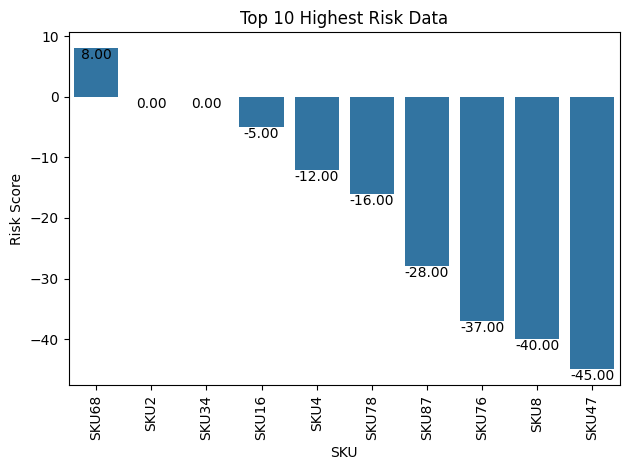

In [20]:
risk_data['Risk Score'] = risk_data['Lead times'] * (1 - risk_data.loc[:, 'Stock levels'])

# Sort risk data by Risk Score in descending order and select top 10 highest risk data
top10_risk_data = risk_data.sort_values(by='Risk Score', ascending=False).head(10)

sns.barplot(top10_risk_data, x = 'SKU', y = 'Risk Score')
for index, value in enumerate(top10_risk_data['Risk Score']):
    plt.text(index, value, f'{value:.2f}', ha='center', va='top')
plt.xlabel('SKU')
plt.ylabel('Risk Score')
plt.title('Top 10 Highest Risk Data')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Inventory Optimization Analysis with EOQ

In [21]:
# Assume holding cost of 0.2
holding_cost = 0.2

# Function to calculate EOQ
def calc_eoq(data):
  S = data['Costs']
  D = data['Number of products sold']
  H = data['Number of products sold'] * holding_cost
  EOQ = np.sqrt((2*S*D)/H)
  return round(EOQ)

In [22]:
data['EOQ'] = calc_eoq(data)

comparison_cols = data[['SKU', 'EOQ', 'Order quantities']]
comparison_cols.head()

,SKU,EOQ,Order quantities
0,SKU0,43.0,96
1,SKU1,71.0,37
2,SKU2,38.0,88
3,SKU3,50.0,59
4,SKU4,96.0,56


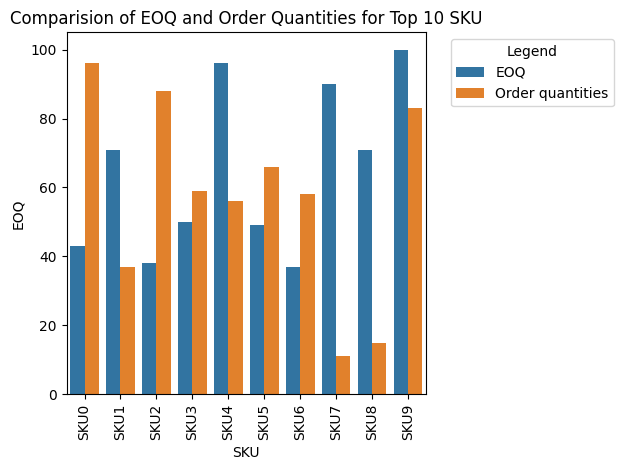

In [23]:
# Extract top 10 rows
top_10_sku = comparison_cols.head(10)

melted_data = top_10_sku.melt(id_vars='SKU',
                                       value_vars=['EOQ', 'Order quantities'],
                                       var_name='Metric',
                                       value_name='Value')

sns.barplot(melted_data, x = 'SKU', y = 'Value', hue = 'Metric')
plt.title('Comparision of EOQ and Order Quantities for Top 10 SKU')
plt.xlabel('SKU')
plt.ylabel('EOQ')
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Customer Segmentation Analysis

In [24]:
avg_rev_by_demo_prod = data.groupby(['Customer demographics', 'Product type'])['Revenue generated'].mean().reset_index()

tot_rev_by_demo_prod = data.groupby(['Customer demographics', 'Product type'])['Revenue generated'].sum().reset_index()

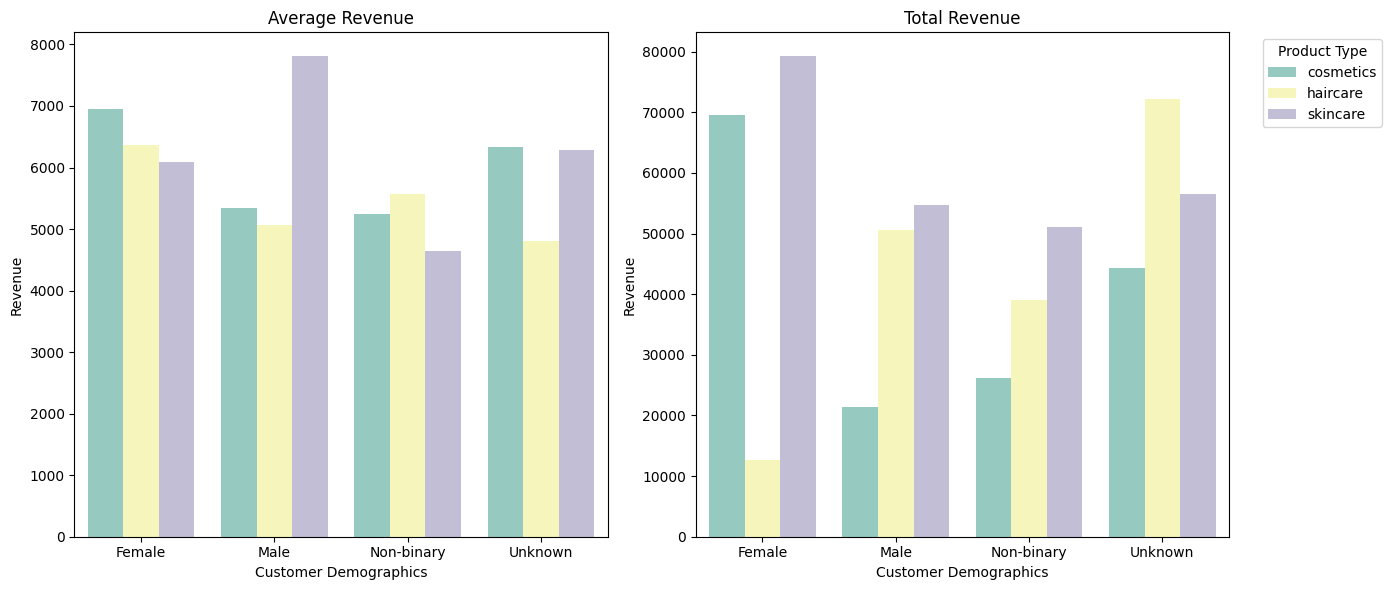

In [25]:
plt.figure(figsize=(14, 6))

# Plot for Average Revenue
plt.subplot(1, 2, 1)
sns.barplot(data=avg_rev_by_demo_prod,
            x='Customer demographics',
            y='Revenue generated',
            hue='Product type',
            palette='Set3',
            legend = False)

plt.title('Average Revenue')
plt.xlabel('Customer Demographics')
plt.ylabel('Revenue')

# Plot for Total Revenue
plt.subplot(1, 2, 2)
sns.barplot(data=tot_rev_by_demo_prod,
            x='Customer demographics',
            y='Revenue generated',
            hue='Product type',
            palette='Set3')

plt.title('Total Revenue')
plt.xlabel('Customer Demographics')
plt.ylabel('Revenue')
plt.legend(title='Product Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Lead Time Optimization Analysis

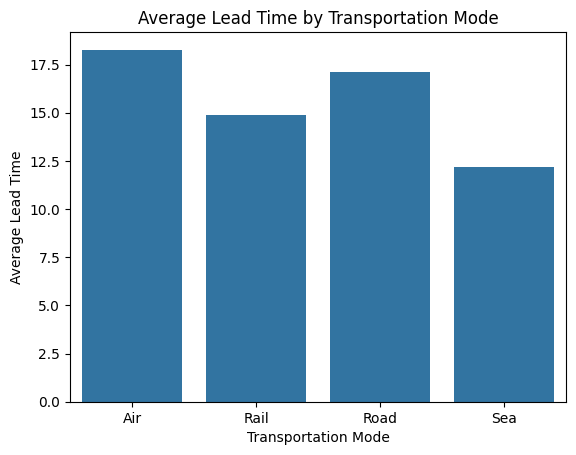

In [26]:
avg_lead_times_transport = data.groupby('Transportation modes')['Lead times'].mean().reset_index()

sns.barplot(avg_lead_times_transport, x = 'Transportation modes', y = 'Lead times')
plt.xlabel('Transportation Mode')
plt.ylabel('Average Lead Time')
plt.title('Average Lead Time by Transportation Mode')
plt.show()

In [27]:
best_transportation_mode = avg_lead_times_transport.loc[avg_lead_times_transport['Lead times'].idxmin()]
best_transportation_mode

,3
Transportation modes,Sea
Lead times,12.176471


In [28]:
best_transportation_data = data[data['Transportation modes']==best_transportation_mode['Transportation modes']]
best_transportation_data.head()

,Product type,SKU,Price,Availability,Number of products sold,Revenue generated,Customer demographics,Stock levels,Lead times,Order quantities,...,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs,EOQ
6,skincare,SKU6,4.078333,48,65,7823.476560,Male,11,15,58,...,14,314,24,1.085069,Pending,1.000911,Sea,Route A,134.369097,37.0
8,cosmetics,SKU8,68.717597,78,150,7517.363211,Female,5,10,15,...,13,769,8,11.423027,Pending,2.709863,Sea,Route B,505.557134,71.0
15,skincare,SKU15,36.989245,94,469,5442.086785,Non-binary,9,8,69,...,14,580,7,97.121282,Pass,2.264406,Sea,Route B,127.861800,36.0
18,haircare,SKU18,36.443628,23,620,9364.673505,Unknown,10,10,46,...,18,374,17,27.107981,Pending,2.231939,Sea,Route A,593.480259,77.0
27,cosmetics,SKU27,92.557361,42,352,2686.457224,Unknown,47,9,62,...,25,291,4,10.528245,Fail,2.864668,Sea,Route B,762.459182,87.0


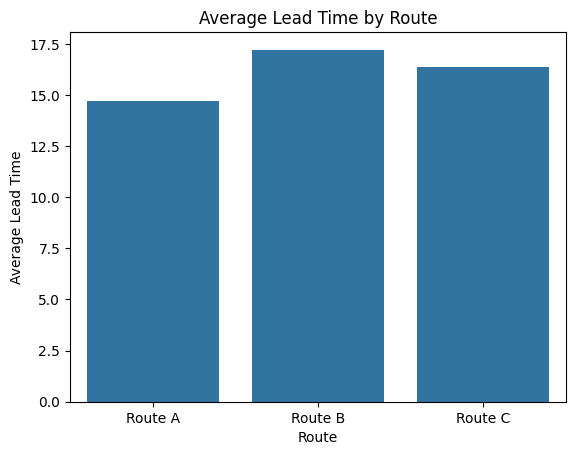

In [29]:
avg_lead_time_route = data.groupby('Routes')['Lead times'].mean().reset_index()

sns.barplot(avg_lead_time_route, x = 'Routes', y = 'Lead times')
plt.xlabel('Route')
plt.ylabel('Average Lead Time')
plt.title('Average Lead Time by Route')
plt.show()

In [30]:
best_route = avg_lead_time_route.loc[avg_lead_time_route['Lead times'].idxmin()]
best_route

,0
Routes,Route A
Lead times,14.697674


In [31]:
best_route_data = data[data['Routes']==best_route['Routes']]
best_route_data.head()

,Product type,SKU,Price,Availability,Number of products sold,Revenue generated,Customer demographics,Stock levels,Lead times,Order quantities,...,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs,EOQ
3,skincare,SKU3,61.163343,68,83,7766.836426,Non-binary,23,13,59,...,24,937,18,35.624741,Fail,4.746649,Rail,Route A,254.776159,50.0
4,skincare,SKU4,4.805496,26,871,2686.505152,Non-binary,5,3,56,...,5,414,3,92.065161,Fail,3.145580,Air,Route A,923.440632,96.0
5,haircare,SKU5,1.699976,87,147,2828.348746,Non-binary,90,27,66,...,10,104,17,56.766476,Fail,2.779194,Road,Route A,235.461237,49.0
6,skincare,SKU6,4.078333,48,65,7823.476560,Male,11,15,58,...,14,314,24,1.085069,Pending,1.000911,Sea,Route A,134.369097,37.0
11,skincare,SKU11,90.635460,95,960,6099.944116,Female,46,23,60,...,28,362,11,27.592363,Pending,0.021170,Air,Route A,126.723033,36.0


## Machine Learning Model

### Demand Forecasting

In [32]:
# Define features and target
X = data[['Price', 'Availability', 'Stock levels', 'Lead times', 'Order quantities']]
y = data['Number of products sold']

In [33]:
# Define number of folds for cross-validation
num_folds = 10

# Initialize lists to store evaluation metrics
mae_scores = []
mse_scores = []
r2_scores = []
rmse_scores = []

# Initialize KFold with the desired number of folds
kf = KFold(n_splits=num_folds, shuffle = True, random_state = 42)

In [34]:
# Define the parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'mean_squared_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
}

In [36]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create LightGBM datasets for training and testing
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    # Add early stopping
    num_round = 100

    # Train the model with early stopping
    bst = lgb.train(
        params,
        train_data,
        num_round,
        valid_sets=[test_data])

    # Make predictions on the test set
    y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Calculate the target range
    target_range = np.max(y_test) - np.min(y_test)

    # Calculate metrics as percentages
    percentage_mse = (mse / target_range) * 100
    percentage_rmse = (rmse / target_range) * 100
    percentage_mae = (mae / target_range) * 100
    percentage_r2 = (r2 * 100)

    # Append the scores to the respective lists
    mse_scores.append(percentage_mse)
    rmse_scores.append(percentage_rmse)
    mae_scores.append(percentage_mae)
    r2_scores.append(percentage_r2)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135
[LightGBM] [Info] Number of data points in the train set: 90, number of used features: 5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 449.877778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

In [38]:
# Calculate the average scores over all folds
avg_mse = np.mean(mse_scores)
avg_rmse = np.mean(rmse_scores)
avg_mae = np.mean(mae_scores)
avg_r2 = np.mean(r2_scores)

# Print the results
print(f"Average Mean Squared Error: {avg_mse:.2f}%")
print(f"Average Root Mean Squared Error: {avg_rmse:.2f}%")
print(f"Average Mean Absolute Error: {avg_mae:.2f}%")
print(f"Average R-squared: {avg_r2:.2f}%")

Average Mean Squared Error: 12074.33%
Average Root Mean Squared Error: 37.43%
Average Mean Absolute Error: 32.81%
Average R-squared: -22.92%


### Cost Optimization

In [39]:
X = data['Production volumes'].values.reshape(-1, 1)
y = data['Manufacturing costs'].values

In [40]:
# Define number of folds for cross-validation
num_folds = 5

# Initialize lists to store evaluation metrics
mae_scores = []
mse_scores = []
r2_scores = []
rmse_scores = []

In [41]:
# Initialize and fit the scaler
scaler = MinMaxScaler()
scaler.fit(X)

# Create KFold object
kf = KFold(n_splits=num_folds, shuffle = True, random_state = 42)

In [42]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Scale the data
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create LightGBM datasets for training and testing
    train_data = lgb.Dataset(X_train_scaled, label=y_train)
    test_data = lgb.Dataset(X_test_scaled, label=y_test, reference=train_data)

    # Add early stopping
    num_round = 100

    # Train the model with early stopping
    bst = lgb.train(
        params,
        train_data,
        num_round,
        valid_sets=[test_data])

    # Make predictions on the test set
    y_pred = bst.predict(X_test_scaled, num_iteration=bst.best_iteration)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Calculate the target range
    target_range = np.max(y_test) - np.min(y_test)

    # Calculate metrics as percentages
    percentage_mse = (mse / target_range) * 100
    percentage_rmse = (rmse / target_range) * 100
    percentage_mae = (mae / target_range) * 100
    percentage_r2 = (r2 * 100)

    # Append the scores to the respective lists
    mse_scores.append(percentage_mse)
    rmse_scores.append(percentage_rmse)
    mae_scores.append(percentage_mae)
    r2_scores.append(percentage_r2)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1
[LightGBM] [Info] Start training from score 45.491700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [43]:
# Calculate the average scores over all folds
avg_mse = np.mean(mse_scores)
avg_rmse = np.mean(rmse_scores)
avg_mae = np.mean(mae_scores)
avg_r2 = np.mean(r2_scores)

# Print the results
print(f"Average Mean Squared Error: {avg_mse:.2f}%")
print(f"Average Root Mean Squared Error: {avg_rmse:.2f}%")
print(f"Average Mean Absolute Error: {avg_mae:.2f}%")
print(f"Average R-squared: {avg_r2:.2f}%")

Average Mean Squared Error: 862.28%
Average Root Mean Squared Error: 30.18%
Average Mean Absolute Error: 26.15%
Average R-squared: -1.41%


In [44]:
# Find the most optimal production volume to minimize manufacturing cost
min_production_volume = data['Production volumes'].min()
max_production_volume = 1000
step_size = 100

cheapest_cost = float('inf')
best_production_volume = None

for production_volume in range(min_production_volume, max_production_volume + 1, step_size):
    normalized_production_volume = scaler.transform(np.array([[production_volume]]))
    predicted_cost = bst.predict(normalized_production_volume)

    if predicted_cost[0] < cheapest_cost:
        cheapest_cost = predicted_cost[0]
        best_production_volume = production_volume

print('Most optimal production volume to minimize manufacturing cost:', best_production_volume)
print('The cheapest manufacturing cost:', round(cheapest_cost, 2))

Most optimal production volume to minimize manufacturing cost: 704
The cheapest manufacturing cost: 37.58
